Se encontraron 333 componentes conectados
Componente 1 con área 4315428
Componente 2 con área 5677
Componente 3 con área 284
Componente 4 con área 1623
Componente 5 con área 3420
Componente 6 con área 2881
Componente 7 con área 6562
Componente 8 con área 1215
Componente 9 con área 49
Componente 10 con área 77
Componente 11 con área 86
Componente 12 con área 1109
Componente 13 con área 596
Componente 14 con área 378
Componente 15 con área 257727
Componente 16 con área 7534
Componente 17 con área 5445
Componente 18 con área 4787
Componente 19 con área 6268
Componente 20 con área 6159
Componente 21 con área 68
Componente 22 con área 62
Componente 23 con área 3970
Componente 24 con área 96
Componente 25 con área 70
Componente 26 con área 352
Componente 27 con área 5939
Componente 28 con área 840
Componente 29 con área 4634
Componente 30 con área 49
Componente 31 con área 10584
Componente 32 con área 5436
Componente 33 con área 76
Componente 34 con área 49
Componente 35 con área 5466
Compon

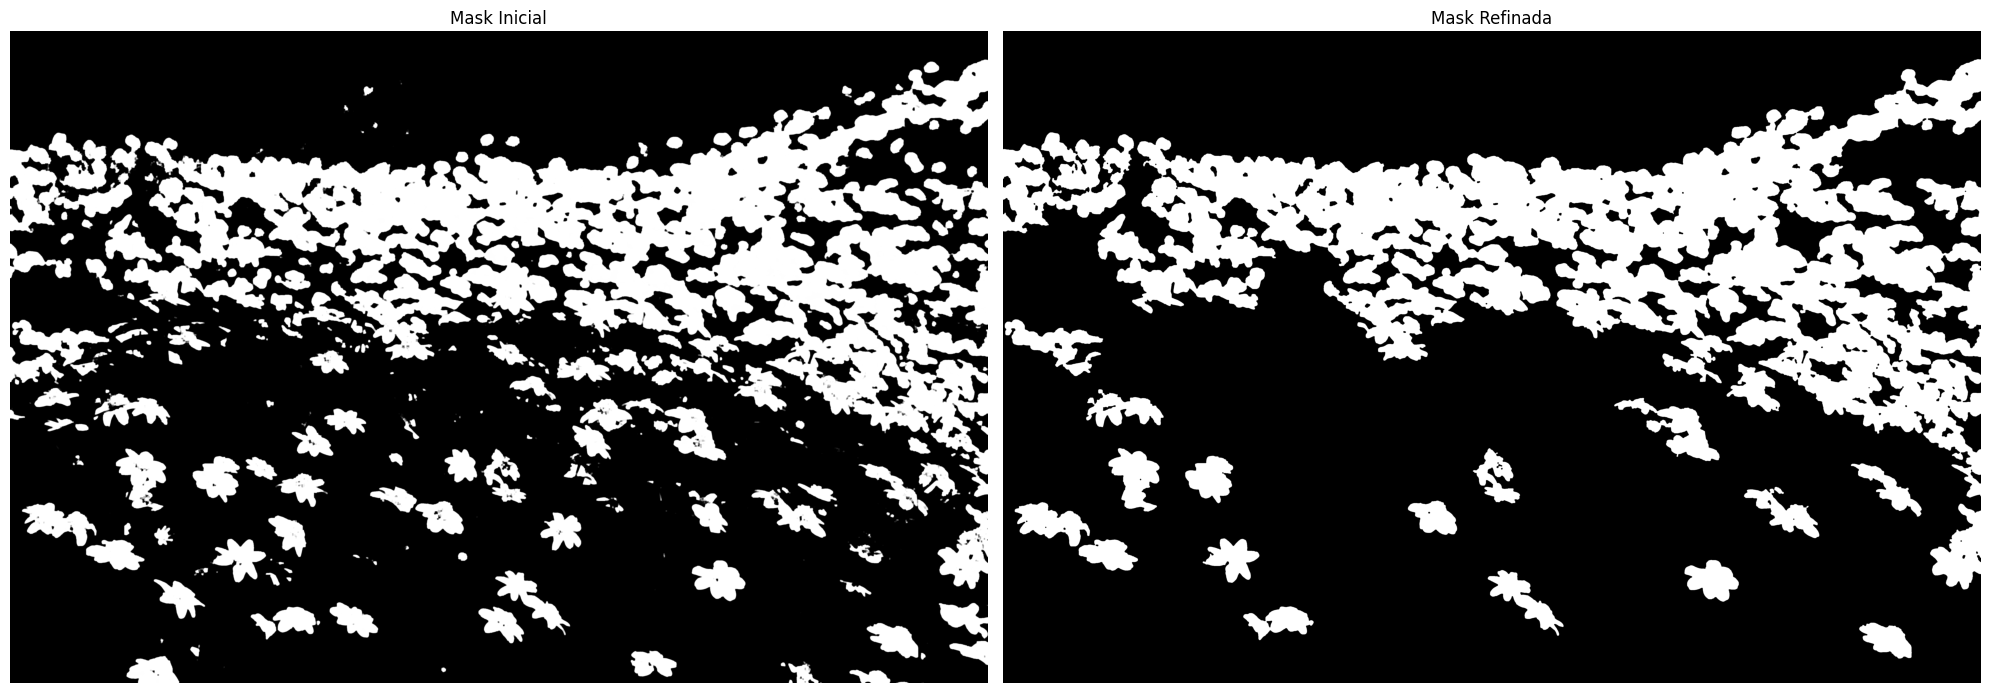

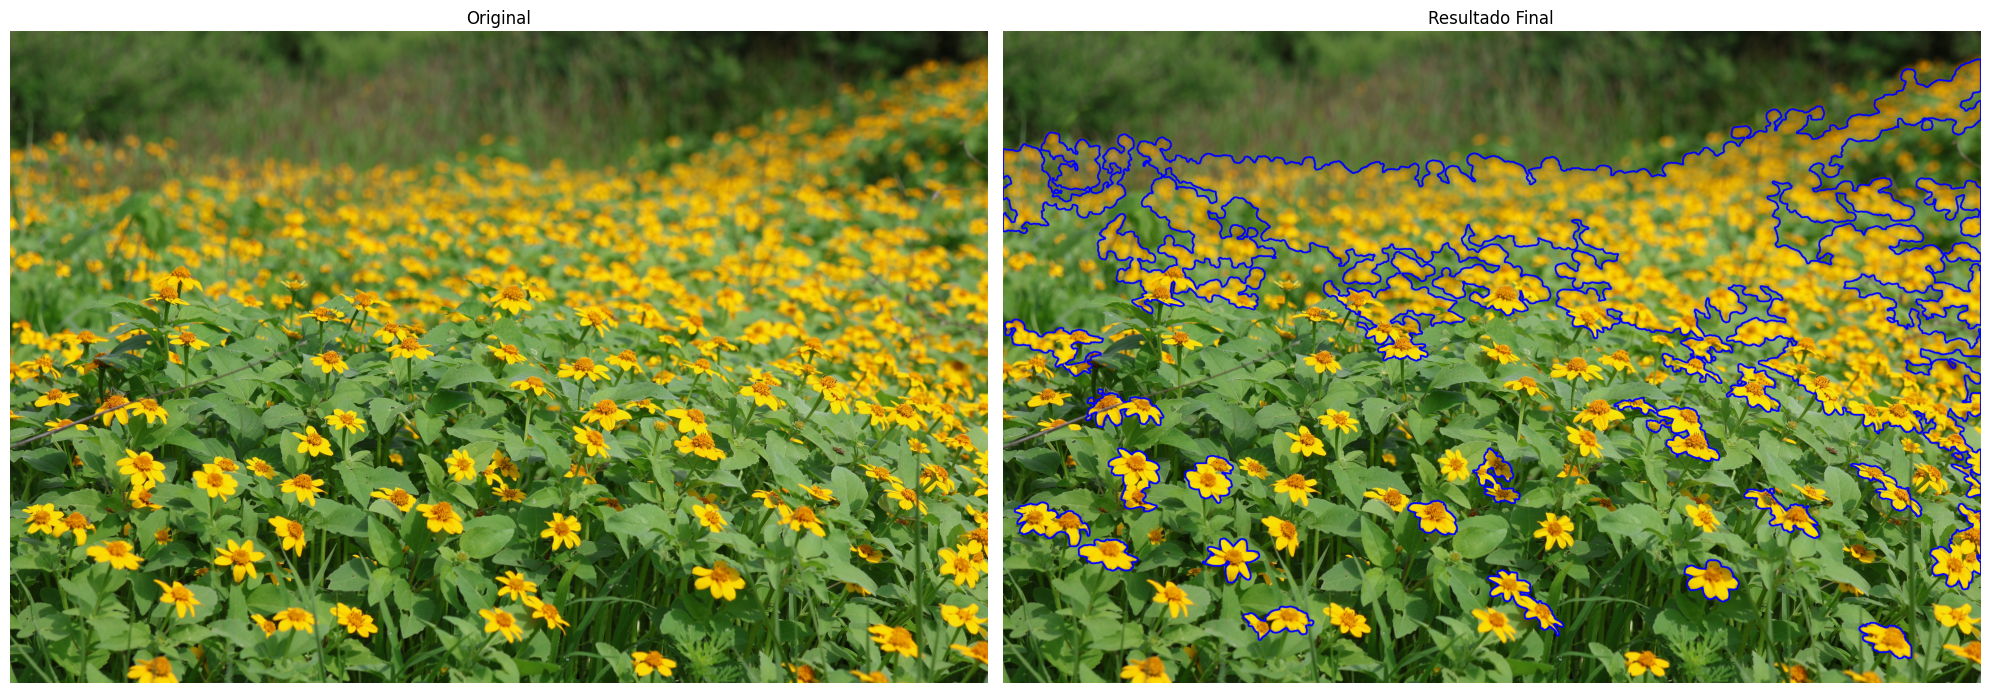

In [157]:
import cv2
import numpy as np

from computacional_perception.group_activity.utils import show_single_image, show_images_side_by_side

flowers = cv2.imread('./land_of_flowers.JPG', cv2.IMREAD_COLOR )
if flowers is None:
    raise ValueError("No se pudo cargar la imagen")

flowers_suavizada = cv2.GaussianBlur(flowers, (5, 5), 0)
flowers_smoothing = cv2.bilateralFilter(flowers_suavizada, 5, 75, 75)

# Convertir de BGR a HSV
flowers_hsv = cv2.cvtColor(flowers_smoothing, cv2.COLOR_BGR2HSV)

# Ecualizar el histograma en el canal V
h, s, v = cv2.split(flowers_hsv)
v = cv2.equalizeHist(v)
flowers_hsv = cv2.merge((h, s, v))


# Definir el rango de colores para las flores amarillas (ajustar los valores segun la imagen)
# Primer rango para tonos bajos de amarillo
lower_yellow = np.array([15, 100, 100])
upper_yellow = np.array([25, 255, 255])
mask1 = cv2.inRange(flowers_hsv, lower_yellow, upper_yellow)

# Segundo rango para tonos altos de amarillo
lower_yellow = np.array([25, 100, 100])
upper_yellow = np.array([35, 255, 255])
mask2 = cv2.inRange(flowers_hsv, lower_yellow, upper_yellow)

# Combinar las dos mascaras
mask = mask1 + mask2

# Definir el rango de verde (ajusta según tu imagen)
lower_green = np.array([40, 40, 40])
upper_green = np.array([70, 255, 255])
mask_green = cv2.inRange(flowers_hsv, lower_green, upper_green)

# Restar la máscara verde de la máscara original de amarillo
mask = cv2.subtract(mask, mask_green)

# Suavisar la mascara para reducir el ruido
mask = cv2.GaussianBlur(mask, (5, 5), 0)

# Operaciones morfológicas
kernel = np.ones((7, 7), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Eliminar componentes conectados pequeños
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
min_size = 10000  # Tamaño mínimo ajustado
new_mask = np.zeros_like(mask)

print(f"Se encontraron {num_labels} componentes conectados")

for i in range(1, num_labels):  # Ignorar fondo
    print(f"Componente {i} con área {stats[i, cv2.CC_STAT_AREA]}")
    if min_size <= stats[i, cv2.CC_STAT_AREA] >= 40000:
        new_mask[labels == i] = 255

# Suavizar con filtro mediana
final_mask = cv2.medianBlur(new_mask, 5)

# Aplicar una apertura adicional para eliminar ruido pequeño
kernel = np.ones((5, 5), np.uint8)
final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)

# Encontrar contornos
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por área más estricta
filtered_contours = [c for c in contours if cv2.contourArea(c) > 1500]

# Dibujar los contornos en la imagen original
result = flowers.copy()
cv2.drawContours(result, filtered_contours, -1, (255, 0, 0), 10)

# Mostrar imágenes
show_images_side_by_side(mask, final_mask, 'Mask Inicial', 'Mask Refinada', 10)
show_images_side_by_side(flowers, result, 'Original', 'Resultado Final', 10)

